# MARKOV Strategy

- Buy à l'ouverture de la bougie consécutive à X bougie down
- Sell à la cloture de cette bougie  
- Ne fonctionne pas. 

In [1]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import os
import warnings

from __future__ import annotations
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting import set_bokeh_output
from glob import glob
from pathlib import Path
from scipy.stats import skew, kurtosis
from tabulate import tabulate 
from tqdm import tqdm
from tqdm import TqdmWarning
from typing import List

warnings.filterwarnings("ignore", category=TqdmWarning)
set_bokeh_output(notebook=False)
warnings.filterwarnings(
    "ignore",
    message="Jupyter Notebook detected. Setting Bokeh output to notebook."
)

# Définir le répertoire contenant vos fichiers parquet
data_dir = "../../data/crypto_data"

# Lister tous les fichiers .parquet
all_files = glob(os.path.join(data_dir, "*.parquet"))
for i in all_files:
    print(i)

/Users/sloutmyv/Documents/Github/trading-overview/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sloutmyv/Documents/Github/trading-overview/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

../../data/crypto_data/btcusdc_15m.parquet
../../data/crypto_data/btcusdc_1h.parquet
../../data/crypto_data/btcusdc_1m.parquet
../../data/crypto_data/btcusdc_1d.parquet
../../data/crypto_data/btcusdc_4h.parquet


In [2]:
# Charger le fichier BTCUSDC en timeframe 1d
btc_file = data_dir + "/btcusdc_1d.parquet"
df = pd.read_parquet(btc_file)

# Vérifier le chargement
print(df.shape)
df.tail()

(2197, 12)


,open_time,open,high,low,close,volume,close_time,quote_asset_volume,nb_trades,taker_buy_base,taker_buy_quote,ignore
2192,1748304000000,109478.01,110799.10,107547.13,108992.92,4879.95661,1748390399999,5.345024e+08,938591,2301.80236,2.522084e+08,0.0
2193,1748390400000,108992.92,109334.92,106814.85,107817.98,3549.21863,1748476799999,3.838646e+08,825601,1602.79008,1.733672e+08,0.0
2194,1748476800000,107817.98,108941.17,105333.00,105586.03,4356.44792,1748563199999,4.672355e+08,1109751,2141.01011,2.296995e+08,0.0
2195,1748563200000,105586.03,106342.00,103657.40,104041.77,5076.54853,1748649599999,5.333837e+08,1301466,2477.16699,2.603056e+08,0.0
2196,1748649600000,104041.76,104343.15,103127.00,103671.99,789.23508,1748735999999,8.187079e+07,212000,353.08902,3.663033e+07,0.0


In [3]:
# -------------------------------------------------------------------
# Le jeu de donnée extrait de Binance comporte quelques erreurs dans les dates. Cette fonction permet de reconstruire l'index 
# temporel pour la suite. 
# Paramètres à ajuster par l'utilisateur :
#   - df : votre DataFrame d'origine contenant la colonne 'open_time'
#   - time_decrement : chaîne définissant l'unité de décrémentation ("4H", "1H", "1T", "1D", etc.)
# -------------------------------------------------------------------

def reconstruire_index_temporel(df: pd.DataFrame, time_decrement: str) -> pd.DataFrame:
    # 1. Filtrer les colonnes souhaitées
    df_filtered = df[['open', 'high', 'low', 'close', 'volume']].copy()
    df_filtered = df_filtered.rename(
    columns=dict(
        open="Open",
        high="High",
        low="Low",
        close="Close",
        volume="Volume",
    )
)

    # 2. Récupérer le dernier timestamp de 'open_time' (en millisecondes)
    last_ts = df['open_time'].iloc[-1]
    last_date = pd.to_datetime(last_ts, unit='ms')

    # 3. Construire l'objet Timedelta selon time_decrement
    #    Pandas accepte des strings comme "4H" (4 heures), "1H" (1 heure), "15T" (15 minutes), "1D" (1 jour), etc.
    delta = pd.Timedelta(time_decrement)

    # 4. Calculer la date de départ : 
    #    start_date = last_date - (n-1) * delta
    n = len(df_filtered)
    start_date = last_date - delta * (n - 1)

    # 5. Générer la plage de dates avec freq=delta
    date_index = pd.date_range(start=start_date, periods=n, freq=delta)

    # 6. Assigner l'index 'Date' au DataFrame filtré
    df_filtered.index = date_index
    df_filtered.index.name = 'Date'

    return df_filtered

time_decrement = "1D"
df_initial = reconstruire_index_temporel(df, time_decrement)
print(df_initial.head())


               Open     High      Low    Close       Volume
Date                                                       
2019-05-27  3200.00  3312.32  3000.00  3183.47   283.213859
2019-05-28  3183.47  3257.31  3178.54  3199.27   423.048529
2019-05-29  3192.69  3587.35  3187.25  3494.65  1163.940291
2019-05-30  3507.62  3683.35  3428.34  3670.11  1251.139627
2019-05-31  3673.18  3920.00  3618.53  3676.32  2655.242827


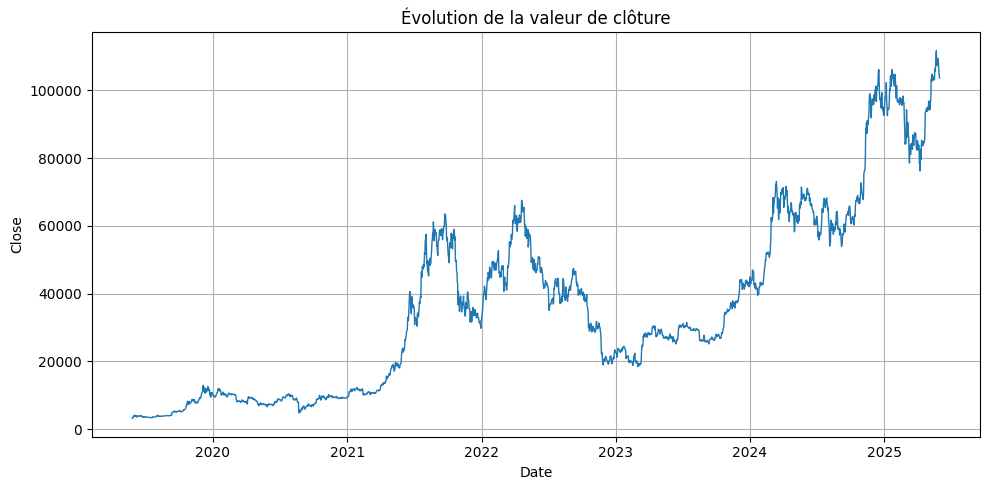

In [4]:
# Vérification que le jeu de donnée est cohérent
# Tracer la colonne 'close' en fonction de l'index temporel
plt.figure(figsize=(10, 5))
plt.plot(df_initial.index, df_initial['Close'], linewidth=1)
plt.title("Évolution de la valeur de clôture")
plt.xlabel("Date")
plt.ylabel("Close")
plt.grid(True)
plt.tight_layout()
plt.show()

Bougies df_initial : 2197
Bougies df_train : 1097
Bougies df_test : 731


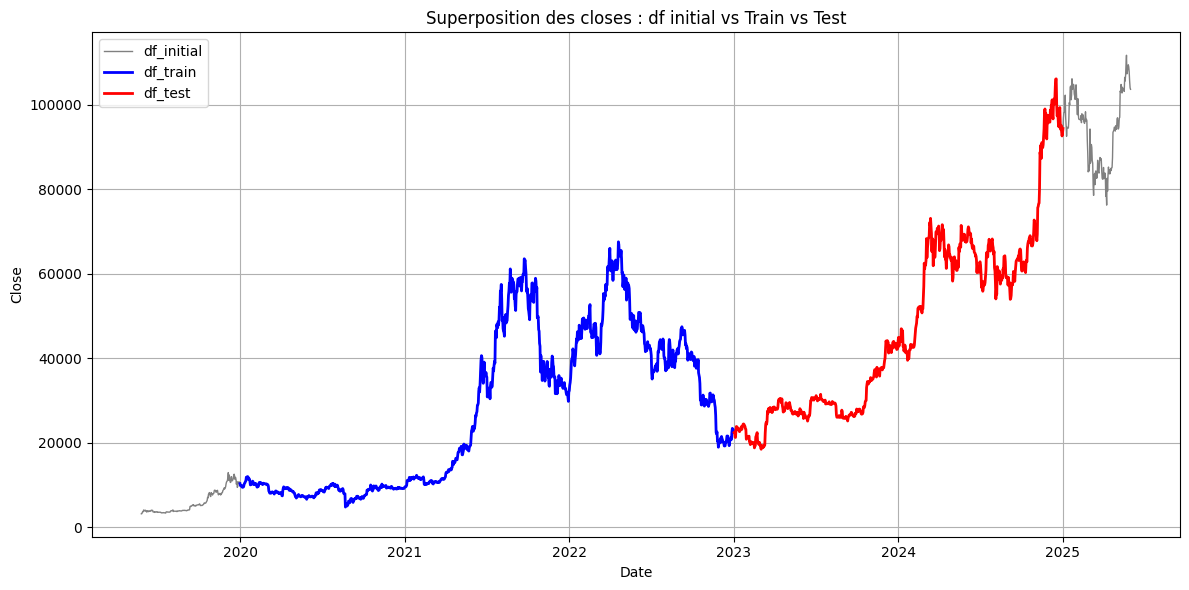

In [5]:
# Batir le jeu de donnée d'entrainement et le jeu de donnée de test
# 1. Définir les bornes de dates pour l'entraînement et le test
train_start, train_end = "2020-01-01", "2023-01-01"
test_start, test_end   = "2023-01-02", "2025-01-01"

# 2. S'assurer que l'index est de type datetime
df_initial.index = pd.to_datetime(df_initial.index)

# 3. Filtrer pour créer df_train et df_test
df_train = df_initial.loc[train_start:train_end].copy()
df_test  = df_initial.loc[test_start:test_end].copy()

print(f"Bougies df_initial : {df_initial.shape[0]}")
print(f"Bougies df_train : {df_train.shape[0]}")
print(f"Bougies df_test : {df_test.shape[0]}")

plt.figure(figsize=(12, 6))

# Tracer la série 'Close' du DataFrame complet
plt.plot(df_initial.index, df_initial['Close'], label='df_initial', color='gray', linewidth=1)

# Tracer la série 'Close' du DataFrame d’entraînement
plt.plot(df_train.index, df_train['Close'], label='df_train', color='blue', linewidth=2)

# Tracer la série 'Close' du DataFrame de test
plt.plot(df_test.index, df_test['Close'], label='df_test', color='red', linewidth=2)

plt.title("Superposition des closes : df initial vs Train vs Test")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from backtesting import Strategy

class MarkovStrategy(Strategy):
    """
    Avec trade_on_close=True, on détecte 3 bougies baissières
    à la clôture et on achète au prix de cette même clôture.
    On ferme sur la clôture suivante.
    """
    n_down        = 3     # nombre de bougies baissières
    position_size = 0.50  # fraction d’equity

    def init(self):
        pass

    def next(self):
        # 1) Si pas encore positionné, cherche 3 closes baissières
        if not self.position:
            if len(self.data) < self.n_down + 1:
                return

            # Vérifie les n_down dernières bougies (i-1, i-2, ..., i-n_down)
            for i in range(1, self.n_down + 1):
                if self.data.Close[-i] >= self.data.Open[-i]:
                    return  # si l’une n’est pas baissière, on stop

            # Si on arrive ici, on a 3 bougies baissières d’affilée
            # On entre au prix de clôture de la bougie courante
            self.buy(size=self.position_size)

        # 2) Si on est déjà en position et qu’on envoie un ordre de clôture,
        #    avec trade_on_close=True, cela se fera également à la clôture de la bougie courante
        elif self.position:
            self.position.close()


In [7]:
df_train_bt = df_train.copy()
df_test_bt = df_test.copy()

# ─── Conversion BTC → satoshis pour éviter le fractional trading ─────────────
SATOSHIS_PER_BTC = 100_000_000
for col in ["Open", "High", "Low", "Close"]:
    df_train_bt[col] /= SATOSHIS_PER_BTC
    df_test_bt[col] /= SATOSHIS_PER_BTC

In [8]:
# ─── Paramètres utilisateur ───────────────────────────────────────────────────
INITIAL_CAPITAL = 3_000         # Capital de départ (USDC)
COMMISSION = 0.01               # 0,05 % de frais (réduit) → 0.01 = 1 %

bt = Backtest(
    df_train_bt,
    MarkovStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

stats = bt.run(
    n_down=3,
    position_size=0.5,
    )

# ─── Mise en forme & export des statistiques ────────────────────────────────
def _beautify(val):
    """Pourcentages jolis pour |val| < 1, sinon 2 décimales."""
    if isinstance(val, (float, int)):
        if abs(val) < 1 and val != 0:
            return f"{val:.2%}"
        return f"{val:.2f}"
    return val

stats_df = stats.to_frame(name="Value")
stats_df.index.name = "Metric"

stats_formatted = stats_df.head(31).map(_beautify)

mapper = "map" if hasattr(stats_df, "map") else "applymap"
stats_formatted = getattr(stats_df.head(31), mapper)(_beautify)

print("\n===== Statistiques EMA 12/26 =====")
print(tabulate(
    stats_formatted.reset_index(),   # tabulate n'aime pas les index hiérarchiques
    headers=["Metric", "Value"],
    tablefmt="github",
))

# ─── Plot du backtest ────────────────────────────────────────────────────────
bt.plot()
plt.show()



===== Statistiques EMA 12/26 =====
|    | Metric                 | Value               |
|----|------------------------|---------------------|
|  0 | Start                  | 2020-01-01 00:00:00 |
|  1 | End                    | 2023-01-01 00:00:00 |
|  2 | Duration               | 1096 days 00:00:00  |
|  3 | Exposure Time [%]      | 12.03               |
|  4 | Equity Final [$]       | 1742.13             |
|  5 | Equity Peak [$]        | 3036.40             |
|  6 | Commissions [$]        | 1570.92             |
|  7 | Return [%]             | -41.93              |
|  8 | Buy & Hold Return [%]  | 119.78              |
|  9 | Return (Ann.) [%]      | -16.54              |
| 10 | Volatility (Ann.) [%]  | 7.43                |
| 11 | CAGR [%]               | -16.56              |
| 12 | Sharpe Ratio           | -2.23               |
| 13 | Sortino Ratio          | -2.49               |
| 14 | Calmar Ratio           | -38.14%             |
| 15 | Alpha [%]              | -44.85        

In [9]:
# Recherche des meilleurs paramètres pour la stratégie 

# ─── Définition de la grille de recherche ─────────────────────────────────────
X_DOWN = range(1, 5, 1)  
POSITION_SIZES = [0.25, 0.5, 0.75]

TOP_N_PRINT = 10 # Affichage de X meilleurs résultats

# Liste de l'ensemble des combinaisons possibles
param_grid = list(itertools.product(X_DOWN, POSITION_SIZES))

print(f"[i] {len(param_grid)} combinaisons à tester")

# ─── Loop de backtests & collecte des stats ───────────────────────────────────
results = []

bt_train = Backtest(
    df_train_bt,
    MarkovStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

for x_down, p_size in tqdm(param_grid, ncols=80):
    stats = bt_train.run(
        n_down=x_down,
        position_size=p_size,
    )
    results.append(
        {
            "n_down": x_down,
            "position_size": p_size,
            **stats.to_dict(),
        }
    )


# ─── DataFrame final + tri sur le rendement net ──────────────────────────────
res_df = pd.DataFrame(results).sort_values("Return [%]", ascending=False)

# ─── Affichage console du TOP N ──────────────────────────────────────────────

cols_show = [
    "n_down",
    "position_size",
    "Return [%]",
    "Sharpe Ratio",
    "Max. Drawdown [%]",
]

print(f"\n=== TOP {TOP_N_PRINT} par Return [%] (train) ===")
print(
    tabulate(
        res_df.head(TOP_N_PRINT)[cols_show],
        headers="keys",
        tablefmt="github",
        floatfmt=".2f",
    )
)

[i] 12 combinaisons à tester


100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 38.70it/s]


=== TOP 10 par Return [%] (train) ===
|    |   n_down |   position_size |   Return [%] |   Sharpe Ratio |   Max. Drawdown [%] |
|----|----------|-----------------|--------------|----------------|---------------------|
|  9 |     4.00 |            0.25 |       -14.26 |          -1.05 |              -17.15 |
|  6 |     3.00 |            0.25 |       -23.60 |          -2.10 |              -24.56 |
| 10 |     4.00 |            0.50 |       -27.02 |          -1.11 |              -31.74 |
| 11 |     4.00 |            0.75 |       -38.33 |          -1.16 |              -44.08 |
|  7 |     3.00 |            0.50 |       -41.93 |          -2.23 |              -43.38 |
|  3 |     2.00 |            0.25 |       -50.78 |          -3.20 |              -50.79 |
|  8 |     3.00 |            0.75 |       -56.08 |          -2.36 |              -57.71 |
|  0 |     1.00 |            0.25 |       -76.12 |          -5.55 |              -76.48 |
|  4 |     2.00 |            0.50 |       -76.23 |          -

In [16]:
class MarkovMultiStrategy(Strategy):
    """
    Stratégie Markov permettant plusieurs trades en parallèle.
    Achète à la clôture de la n_down-ième bougie baissière consécutive.
    Revend à la clôture de la bougie suivante.
    """
    
    # Paramètres configurables
    n_down = 3
    max_trades = 3
    position_size = 0.5
    
    def init(self):
        """Initialisation de la stratégie."""
        # La taille de chaque trade individuel est calculée à partir de la taille de position
        # totale souhaitée divisée par le nombre maximum de trades simultanés.
        self.trade_size = self.position_size / self.max_trades
    
    def next(self):
        """Logique exécutée à chaque bougie."""
        
        # 1. Gérer les sorties : fermer les trades ouverts à la bougie précédente.
        # On itère sur une copie de la liste `self.trades` car `trade.close()` la modifie.
        for trade in self.trades[:]:
            # La condition est : la bougie actuelle est la bougie qui suit celle de l'entrée.
            if len(self.data) - 1 == trade.entry_bar + 1:
                # print(f"VENTE bar {len(self.data) - 1}: Fermeture du trade entré en bar {trade.entry_bar}")
                trade.close()

        # 2. Gérer les entrées : ouvrir une nouvelle position si les conditions sont remplies.
        # On vérifie s'il y a un signal d'entrée ET si on n'a pas atteint le max de trades ouverts.
        if len(self.trades) < self.max_trades and self._is_entry_signal():
            # print(f"ACHAT bar {len(self.data) - 1}: taille={self.trade_size:.4f}")
            self.buy(size=self.trade_size)

    def _is_entry_signal(self):
        """
        Vérifie s'il y a un signal d'entrée (n_down bougies baissières consécutives).
        Retourne True si le signal est présent, False sinon.
        """
        # Pas assez d'historique pour évaluer la condition.
        if len(self.data.Close) < self.n_down:
            return False
            
        # Vérifier que les `n_down` dernières bougies sont bien baissières.
        # On regarde les bougies de `(maintenant - n_down + 1)` jusqu'à `maintenant`.
        for i in range(self.n_down):
            # index de la bougie à vérifier dans le passé
            idx = -1 - i
            if self.data.Close[idx] >= self.data.Open[idx]:
                # Si une seule bougie n'est pas baissière, le signal est invalide.
                return False
        
        # Si la boucle se termine sans retourner False, toutes les bougies étaient baissières.
        return True

In [17]:
# ─── Paramètres utilisateur ───────────────────────────────────────────────────
INITIAL_CAPITAL = 3_000  # Capital de départ (USDC)
COMMISSION = 0.01  # 1% de frais
MAX_TRADES = 3  # Nombre maximum de trades en parallèle
POSITION_SIZE = 0.5  # Taille de position de base

# Configuration du backtest
bt = Backtest(
    df_train_bt,  # Vos données
    MarkovMultiStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=False,  # Important : permettre les ordres multiples
)

# Exécution du backtest
stats = bt.run(
    n_down=3,
    max_trades=MAX_TRADES,
    position_size=POSITION_SIZE,
)

# ─── Analyse des résultats ─────────────────────────────────────────────────
def _beautify(val):
    """Pourcentages jolis pour |val| < 1, sinon 2 décimales."""
    if isinstance(val, (float, int)):
        if abs(val) < 1 and val != 0:
            return f"{val:.2%}"
        return f"{val:.2f}"
    return val

stats_df = stats.to_frame(name="Value")
stats_df.index.name = "Metric"

# Compatibilité pandas
try:
    stats_formatted = stats_df.head(31).map(_beautify)
except AttributeError:
    stats_formatted = stats_df.head(31).applymap(_beautify)

print("\n===== Statistiques Stratégie Markov Multi-Trades =====")
print(f"Paramètres:")
print(f"- Nombre de bougies down: {3}")
print(f"- Trades max en parallèle: {MAX_TRADES}")
print(f"- Taille de position ajustée: {POSITION_SIZE/MAX_TRADES:.3f}")
print(f"- Capital initial: {INITIAL_CAPITAL:,} USDC")
print()

from tabulate import tabulate
print(tabulate(
    stats_formatted.reset_index(),
    headers=["Metric", "Value"],
    tablefmt="github",
))

# ─── Visualisation ────────────────────────────────────────────────────────
bt.plot()
import matplotlib.pyplot as plt
plt.show()

# ─── Analyse additionnelle des trades ────────────────────────────────────
print(f"\n===== Analyse des Trades =====")
trades_df = stats._trades
if len(trades_df) > 0:
    print(f"Nombre total de trades: {len(trades_df)}")
    print(f"Trades gagnants: {len(trades_df[trades_df['PnL'] > 0])}")
    print(f"Trades perdants: {len(trades_df[trades_df['PnL'] < 0])}")
    print(f"Taux de réussite: {len(trades_df[trades_df['PnL'] > 0]) / len(trades_df):.2%}")
    print(f"PnL moyen par trade: {trades_df['PnL'].mean():.2f}")
    print(f"PnL médian par trade: {trades_df['PnL'].median():.2f}")
else:
    print("Aucun trade exécuté")


===== Statistiques Stratégie Markov Multi-Trades =====
Paramètres:
- Nombre de bougies down: 3
- Trades max en parallèle: 3
- Taille de position ajustée: 0.167
- Capital initial: 3,000 USDC

|    | Metric                 | Value               |
|----|------------------------|---------------------|
|  0 | Start                  | 2020-01-01 00:00:00 |
|  1 | End                    | 2023-01-01 00:00:00 |
|  2 | Duration               | 1096 days 00:00:00  |
|  3 | Exposure Time [%]      | 14.04               |
|  4 | Equity Final [$]       | 2262.21             |
|  5 | Equity Peak [$]        | 3007.48             |
|  6 | Commissions [$]        | 907.62              |
|  7 | Return [%]             | -24.59              |
|  8 | Buy & Hold Return [%]  | 119.78              |
|  9 | Return (Ann.) [%]      | -8.96               |
| 10 | Volatility (Ann.) [%]  | 4.10                |
| 11 | CAGR [%]               | -8.97               |
| 12 | Sharpe Ratio           | -2.19               

In [19]:
# Recherche des meilleurs paramètres pour la stratégie 

# ─── Définition de la grille de recherche ─────────────────────────────────────
X_DOWN = range(1, 5, 1)  
MAX_TRADES = range(1,4,1)
POSITION_SIZES = [0.25, 0.5, 0.75]

TOP_N_PRINT = 10 # Affichage de X meilleurs résultats

# Liste de l'ensemble des combinaisons possibles
param_grid = list(itertools.product(X_DOWN, POSITION_SIZES, MAX_TRADES))

print(f"[i] {len(param_grid)} combinaisons à tester")

# ─── Loop de backtests & collecte des stats ───────────────────────────────────
results = []

bt_train = Backtest(
    df_train_bt,
    MarkovMultiStrategy,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=True,
)

for x_down, p_size, m_trade in tqdm(param_grid, ncols=80):
    stats = bt_train.run(
        n_down=x_down,
        position_size=p_size,
        max_trades=m_trade,
    )
    results.append(
        {
            "n_down": x_down,
            "position_size": p_size,
            "max_trades":m_trade,
            **stats.to_dict(),
        }
    )


# ─── DataFrame final + tri sur le rendement net ──────────────────────────────
res_df = pd.DataFrame(results).sort_values("Return [%]", ascending=False)

# ─── Affichage console du TOP N ──────────────────────────────────────────────

cols_show = [
    "n_down",
    "position_size",
    "max_trades",
    "Return [%]",
    "Sharpe Ratio",
    "Max. Drawdown [%]",
]

print(f"\n=== TOP {TOP_N_PRINT} par Return [%] (train) ===")
print(
    tabulate(
        res_df.head(TOP_N_PRINT)[cols_show],
        headers="keys",
        tablefmt="github",
        floatfmt=".2f",
    )
)

[i] 36 combinaisons à tester


100%|███████████████████████████████████████████| 36/36 [00:00<00:00, 41.49it/s]


=== TOP 10 par Return [%] (train) ===
|    |   n_down |   position_size |   max_trades |   Return [%] |   Sharpe Ratio |   Max. Drawdown [%] |
|----|----------|-----------------|--------------|--------------|----------------|---------------------|
| 29 |     4.00 |            0.25 |         3.00 |        -5.93 |          -1.09 |               -6.84 |
| 28 |     4.00 |            0.25 |         2.00 |        -8.79 |          -1.10 |              -10.10 |
| 32 |     4.00 |            0.50 |         3.00 |       -11.59 |          -1.11 |              -13.27 |
| 20 |     3.00 |            0.25 |         3.00 |       -13.10 |          -2.12 |              -13.40 |
| 27 |     4.00 |            0.25 |         1.00 |       -14.26 |          -1.05 |              -17.15 |
| 35 |     4.00 |            0.75 |         3.00 |       -17.00 |          -1.13 |              -19.32 |
| 31 |     4.00 |            0.50 |         2.00 |       -17.00 |          -1.13 |              -19.32 |
| 19 |     3.00 

In [31]:
from backtesting import Strategy

# La fonction ATR reste la même...
def ATR(df, n):
    # ... code de la fonction ATR ...
    high, low, close = df['High'], df['Low'], df['Close']
    tr1 = pd.Series(high - low)
    tr2 = pd.Series(abs(high - close.shift(1)))
    tr3 = pd.Series(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return tr.ewm(alpha=1/n, adjust=False).mean()

class MarkovMultiStrategyWithSLTP(Strategy):
    """
    Trade sur des données BTC/USDC qui ont été divisées par 100M.
    Affiche les logs en reconvertissant les valeurs en USDC.
    """
    # --- Paramètres de la stratégie ---
    n_down = 3
    max_trades = 3
    position_size = 0.5
    atr_period = 14
    atr_sl_multiplier = 2.0
    risk_reward_ratio = 1.5
    
    # --- Constante pour inverser votre transformation ---
    CONVERSION_FACTOR = 100_000_000
    
    def init(self):
        self.trade_size = self.position_size / self.max_trades
        # L'ATR est calculé sur les données transformées (petits nombres)
        self.atr = self.I(ATR, self.data.df, self.atr_period)
    
    def next(self):
        # Il n'y a PAS besoin de self.data.BTC_USDC_Price ici.

        if len(self.trades) < self.max_trades and self._is_entry_signal():
            
            # --- LOGIQUE DE TRADING (sur les données transformées) ---
            # Toutes ces variables ont des petites valeurs (ex: 0.0007)
            current_atr = self.atr[-1]
            if current_atr <= 0: return

            entry_price = self.data.Close[-1]
            sl_distance = current_atr * self.atr_sl_multiplier
            sl_price = entry_price - sl_distance
            tp_price = entry_price + (sl_distance * self.risk_reward_ratio)
            
            # <--- AFFICHAGE RECONVERTI EN USDC ---
            current_bar = len(self.data) - 1
            print("--- NOUVEL ACHAT (valeurs affichées en USDC) ---")
            print(f"  Barre #{current_bar}")
            # On multiplie chaque valeur par le facteur de conversion pour l'affichage
            print(f"  Prix d'entrée: {(entry_price * self.CONVERSION_FACTOR):,.2f} $")
            print(f"  Volatilité ATR: {(current_atr * self.CONVERSION_FACTOR):,.2f} $")
            print(f"  Risque par unité: {(sl_distance * self.CONVERSION_FACTOR):,.2f} $")
            print(f"  => Stop Loss Placé à: {(sl_price * self.CONVERSION_FACTOR):,.2f} $")
            print(f"  => Take Profit Placé à: {(tp_price * self.CONVERSION_FACTOR):,.2f} $")
            print("--------------------------------------------------\n")
            
            # Le `buy` utilise les valeurs transformées (petits nombres), ce qui est CORRECT
            # car c'est le format des données sur lesquelles le backtest s'exécute.
            self.buy(
                size=self.trade_size,
                sl=sl_price,
                tp=tp_price
            )

    def _is_entry_signal(self):
        if len(self.data.Close) < self.n_down: return False
        for i in range(self.n_down):
            if self.data.Close[-1 - i] >= self.data.Open[-1 - i]: return False
        return True

In [32]:
# ─── Paramètres utilisateur ───────────────────────────────────────────────────
INITIAL_CAPITAL = 3_000  # Capital de départ (USDC)
COMMISSION = 0.01  # 1% de frais
MAX_TRADES = 3  # Nombre maximum de trades en parallèle
POSITION_SIZE = 0.5  # Taille de position de base

# Configuration du backtest
bt = Backtest(
    df_train_bt,  # Vos données
    MarkovMultiStrategyWithSLTP,
    cash=INITIAL_CAPITAL,
    commission=COMMISSION,
    trade_on_close=True,
    exclusive_orders=False,  # Important : permettre les ordres multiples
)

# Exécution du backtest
stats = bt.run(
    n_down=3,
    max_trades=MAX_TRADES,
    position_size=POSITION_SIZE,
)

# ─── Analyse des résultats ─────────────────────────────────────────────────
def _beautify(val):
    """Pourcentages jolis pour |val| < 1, sinon 2 décimales."""
    if isinstance(val, (float, int)):
        if abs(val) < 1 and val != 0:
            return f"{val:.2%}"
        return f"{val:.2f}"
    return val

stats_df = stats.to_frame(name="Value")
stats_df.index.name = "Metric"

# Compatibilité pandas
try:
    stats_formatted = stats_df.head(31).map(_beautify)
except AttributeError:
    stats_formatted = stats_df.head(31).applymap(_beautify)

print("\n===== Statistiques Stratégie Markov Multi-Trades =====")
print(f"Paramètres:")
print(f"- Nombre de bougies down: {3}")
print(f"- Trades max en parallèle: {MAX_TRADES}")
print(f"- Taille de position ajustée: {POSITION_SIZE/MAX_TRADES:.3f}")
print(f"- Capital initial: {INITIAL_CAPITAL:,} USDC")
print()

from tabulate import tabulate
print(tabulate(
    stats_formatted.reset_index(),
    headers=["Metric", "Value"],
    tablefmt="github",
))

# ─── Visualisation ────────────────────────────────────────────────────────
bt.plot()
import matplotlib.pyplot as plt
plt.show()

# ─── Analyse additionnelle des trades ────────────────────────────────────
print(f"\n===== Analyse des Trades =====")
trades_df = stats._trades
if len(trades_df) > 0:
    print(f"Nombre total de trades: {len(trades_df)}")
    print(f"Trades gagnants: {len(trades_df[trades_df['PnL'] > 0])}")
    print(f"Trades perdants: {len(trades_df[trades_df['PnL'] < 0])}")
    print(f"Taux de réussite: {len(trades_df[trades_df['PnL'] > 0]) / len(trades_df):.2%}")
    print(f"PnL moyen par trade: {trades_df['PnL'].mean():.2f}")
    print(f"PnL médian par trade: {trades_df['PnL'].median():.2f}")
else:
    print("Aucun trade exécuté")

--- NOUVEL ACHAT (valeurs affichées en USDC) ---
  Barre #2
  Prix d'entrée: 9,767.51 $
  Volatilité ATR: 614.51 $
  Risque par unité: 1,229.02 $
  => Stop Loss Placé à: 8,538.49 $
  => Take Profit Placé à: 11,611.05 $
--------------------------------------------------

--- NOUVEL ACHAT (valeurs affichées en USDC) ---
  Barre #23
  Prix d'entrée: 10,026.17 $
  Volatilité ATR: 626.72 $
  Risque par unité: 1,253.44 $
  => Stop Loss Placé à: 8,772.73 $
  => Take Profit Placé à: 11,906.34 $
--------------------------------------------------

--- NOUVEL ACHAT (valeurs affichées en USDC) ---
  Barre #31
  Prix d'entrée: 10,109.57 $
  Volatilité ATR: 618.00 $
  Risque par unité: 1,236.00 $
  => Stop Loss Placé à: 8,873.57 $
  => Take Profit Placé à: 11,963.56 $
--------------------------------------------------

--- NOUVEL ACHAT (valeurs affichées en USDC) ---
  Barre #38
  Prix d'entrée: 9,492.70 $
  Volatilité ATR: 571.31 $
  Risque par unité: 1,142.62 $
  => Stop Loss Placé à: 8,350.08 $
 